## Visualizing Multicollinearity in Python

Network Graphs for the win.

### Introduction

#### What is multicollinearity?

Multicollinearity is when two or more features are correlated with each other. Although correlation between the independent and dependent features is desired. multicollinearity of independent features is less desired in some settings. In fact, they can be omitted as they are not necessarily more informative than the feature they are correlated with. Identifying these features is therefore a form of feature selection. As a data scientist, it is **key to identify and understand multicollinearity in a dataset** prior to training predictive models. And even after having trained a model, it is important to limit highly collinear features as it can lead to misleading outcomes when explaining models.  

#### Why visualize multicollinearity?

Checking the correlation between the independent and dependent features is typically done during some exploratory data analysis. It can provide an early insight towards feature importance and thus a good understanding of how informative the features will do to do prediction. For feature selection, you do not have to necessarily visually inspect correlations between features. You can use metrics such as VIF (**Variable Inflation Factors**) to detect multicollinearity. However, it can still be worthwhile to visualize correlation between features as a means of extracting insights about the features of the dataset.

Correlation between features is typically visualized using a **correlation matrix** which in return is visualized with a heatmap showing the correlation factor of each feature in the dataset. Unfortunately, if the dataset has a large amount of features, then all a heatmap may do at that point is draw a nice 8-bit artwork. It can be incredibly difficult to extract any type of information because of the sheer size of the resultign heatmap. **With 50 features, that is a matrix with a shape of 50 X 50.** Colors and intensity may help to distinguish the most important factors, but that will be about it. Surely, there must be a better way. 

In this article, we present **three ways to visualize multicollinearity**. Namely, the de facto heatmap, the clustermap and the interactive network graph visualization. I will highlight the pros and cons of each visualization. 

#### Visualizing strong correlated stocks of the S&P500.

We will use S&P500 stock data (between 01/01/2020 and 31/12/2021) to visualize collinear stocks. With the **yfinance** package, you can simply retrieve the stock market data using the stock ticker symbols. Prior to retrieving the stock data, the S&P500 stock table is scraped from the Wikipedia page to retrieve all current stock information in the S&P500. This includes the names of the stocks, the tickers, the corresponding sector, and more. 

Although we specifically work with time series data in this article, the proposed visualizations are data-agnostic. All we need is the correlation matrix of the resulting DataFrame generated with the Pandas function .corr().

In [1]:
# import all the required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from ipywidgets import Layout, widgets
from google.colab import output
output.enable_custom_widget_manager()
import math
import matplotlib.dates as md
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# S&P500 metadata
sp500_table = payload[0]

In [3]:
sp500_table.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [4]:
# mappings
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values
sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("pastel", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("pastel", len(sp500_sub_sectors)).as_hex()))

# download S&P500 financial data
tickers = list(sp500_tickers)
prices = yf.download(tickers, start="2020-01-01", end="2021-12-31", interval="1d")
prices = prices["Adj Close"]
prices = prices.rename(columns=sp500_names_mapping)

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- CEG: Data doesn't exist for startDate = 1577836800, endDate = 1640908800
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [5]:
prices.head()

,Agilent Technologies,American Airlines Group,Advance Auto Parts,Apple Inc.,AbbVie,AmerisourceBergen,Abiomed,Abbott,Accenture,Adobe Inc.,...,Wynn Resorts,Xcel Energy,ExxonMobil,Dentsply Sirona,Xylem Inc.,Yum! Brands,Zimmer Biomet,Zebra Technologies,Zions Bancorporation,Zoetis
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,84.517059,28.982893,153.283585,73.683556,78.725609,81.561234,168.809998,83.297455,202.451019,334.429993,...,142.405029,58.290573,59.971916,55.652870,77.520622,97.172623,142.187561,259.140015,48.343182,131.958679
2020-01-03,83.160049,27.548195,153.293213,72.967209,77.978333,80.535477,166.820007,82.281967,202.113831,331.809998,...,140.292755,58.570908,59.489780,55.037003,77.976921,96.868271,141.815903,256.049988,47.661003,131.978363
2020-01-06,83.405884,27.219410,150.773880,73.548637,78.593735,81.714615,179.039993,82.713074,200.794022,333.709991,...,140.015091,58.486805,59.946552,55.340054,77.472076,96.811211,140.996307,258.010010,47.080219,130.965103
2020-01-07,83.661552,27.119778,148.985352,73.202744,78.145393,81.129852,180.350006,82.253227,196.458893,333.390015,...,140.679504,58.365334,59.455944,55.633316,77.180832,96.982399,140.872421,256.470001,46.794434,131.407776


In [6]:
# impute
for i, row in prices.iterrows():
    if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)
prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method="bfill")
print(prices.shape)

(504, 499)


In [7]:
# calculate rolling correlation
corr = prices.rolling(60).corr()
corr_ = np.array([corr.loc[i].to_numpy() for i in prices.index if not np.isnan(corr.loc[i].to_numpy()).all()])
corr_ = np.nansum(corr_, axis=0)/len(corr_)
corr_ = pd.DataFrame(columns = prices.columns.tolist(), index=prices.columns.tolist(), data = corr_)

### The heatmap

The correlation heatmap can simply be visualized by generating the correlation matrix with Pandas and plotting the heatmap of the matrix using Seaborn. The result is a heatmap showing the positive, negative and zero correlation factors. The main advantage of the heatmap is that it can be generated very easily with Seaborn. The colors help to distinguish strong and week correlations. The main drawback is that it does not scale well with the number of features. It can be hard to interpret when the number of features is large. The features that are strongly correlated are not grouped, as the order is arbritrary. Moreover, the resulting matrix is symmetric, which means half of the values shown are redundant. The upper/lower triangle of the matrix can be removed with a few extra steps.

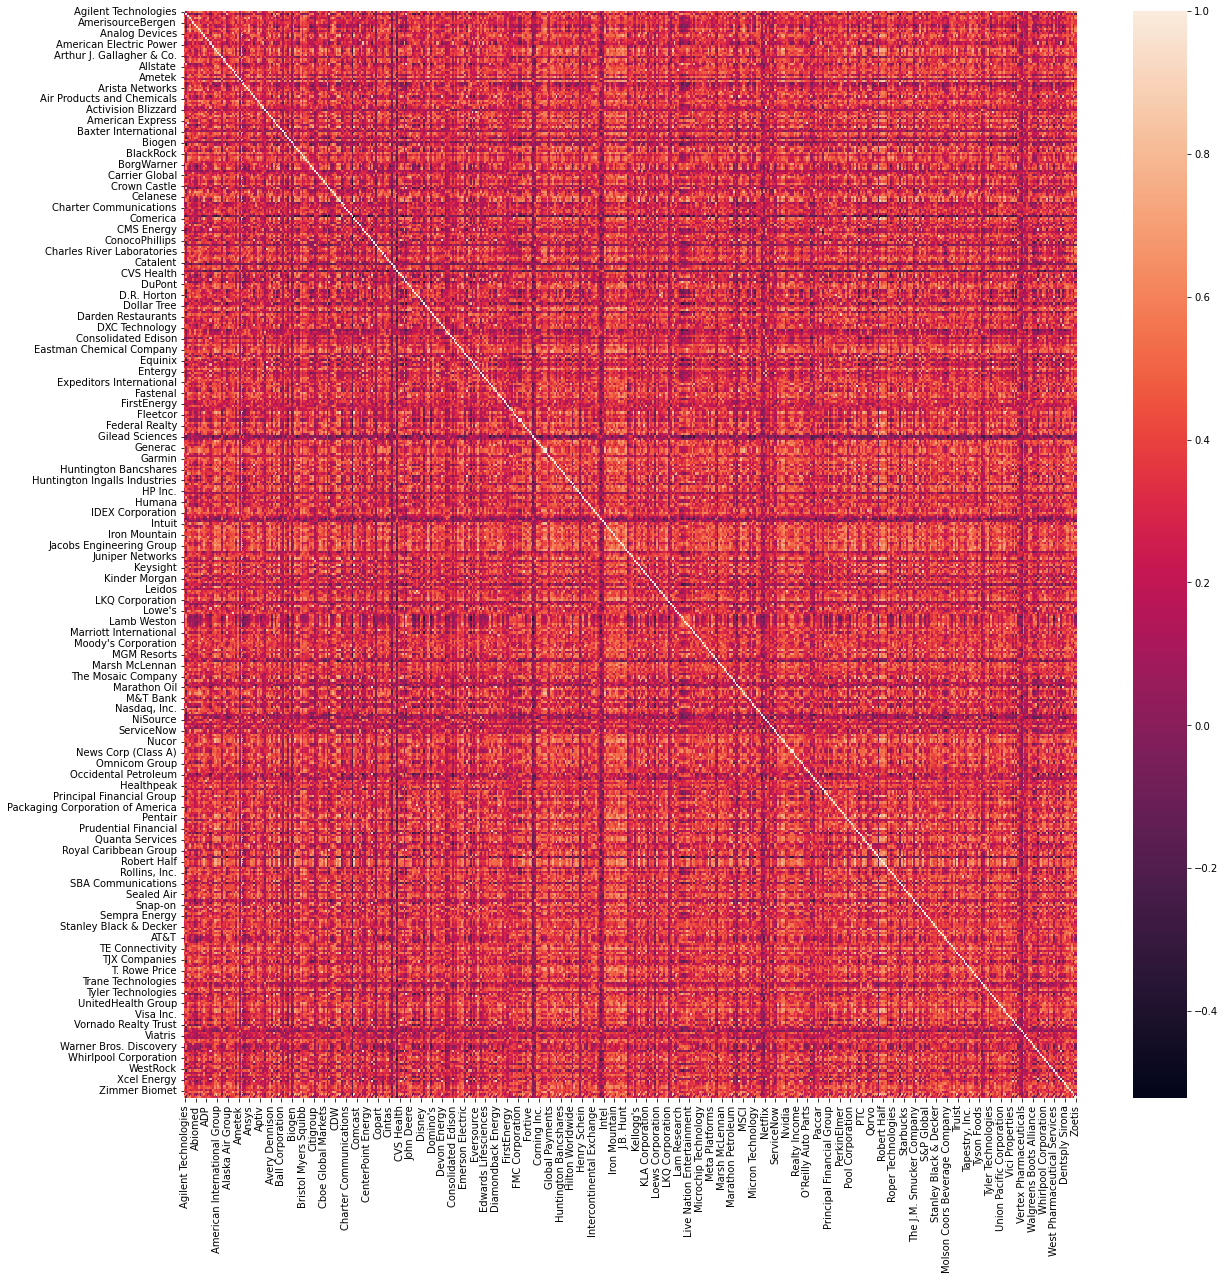

In [8]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_)

### The clustermap

At first glance, the clustermap is mostly similar to the heatmap. It is equally easy to plot. However, it clusters features that are strongly correlated, and shows the tree to understand the clustering on different levels. Unlike the heatmap, the order in which features are sorted serves a purpose. Other than that (and the extra clustermap), it is visually similar to the heatmap. The clustermap is an adequate way to visualize groups of features that are strongly correlated. That is, if there is a limited amount of features that are strongly correlated. That is, if there is a limited amount of features in the dataset. Otherwise, the clustermap can get equally confusing to interpret when inspecting collinear features. 

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


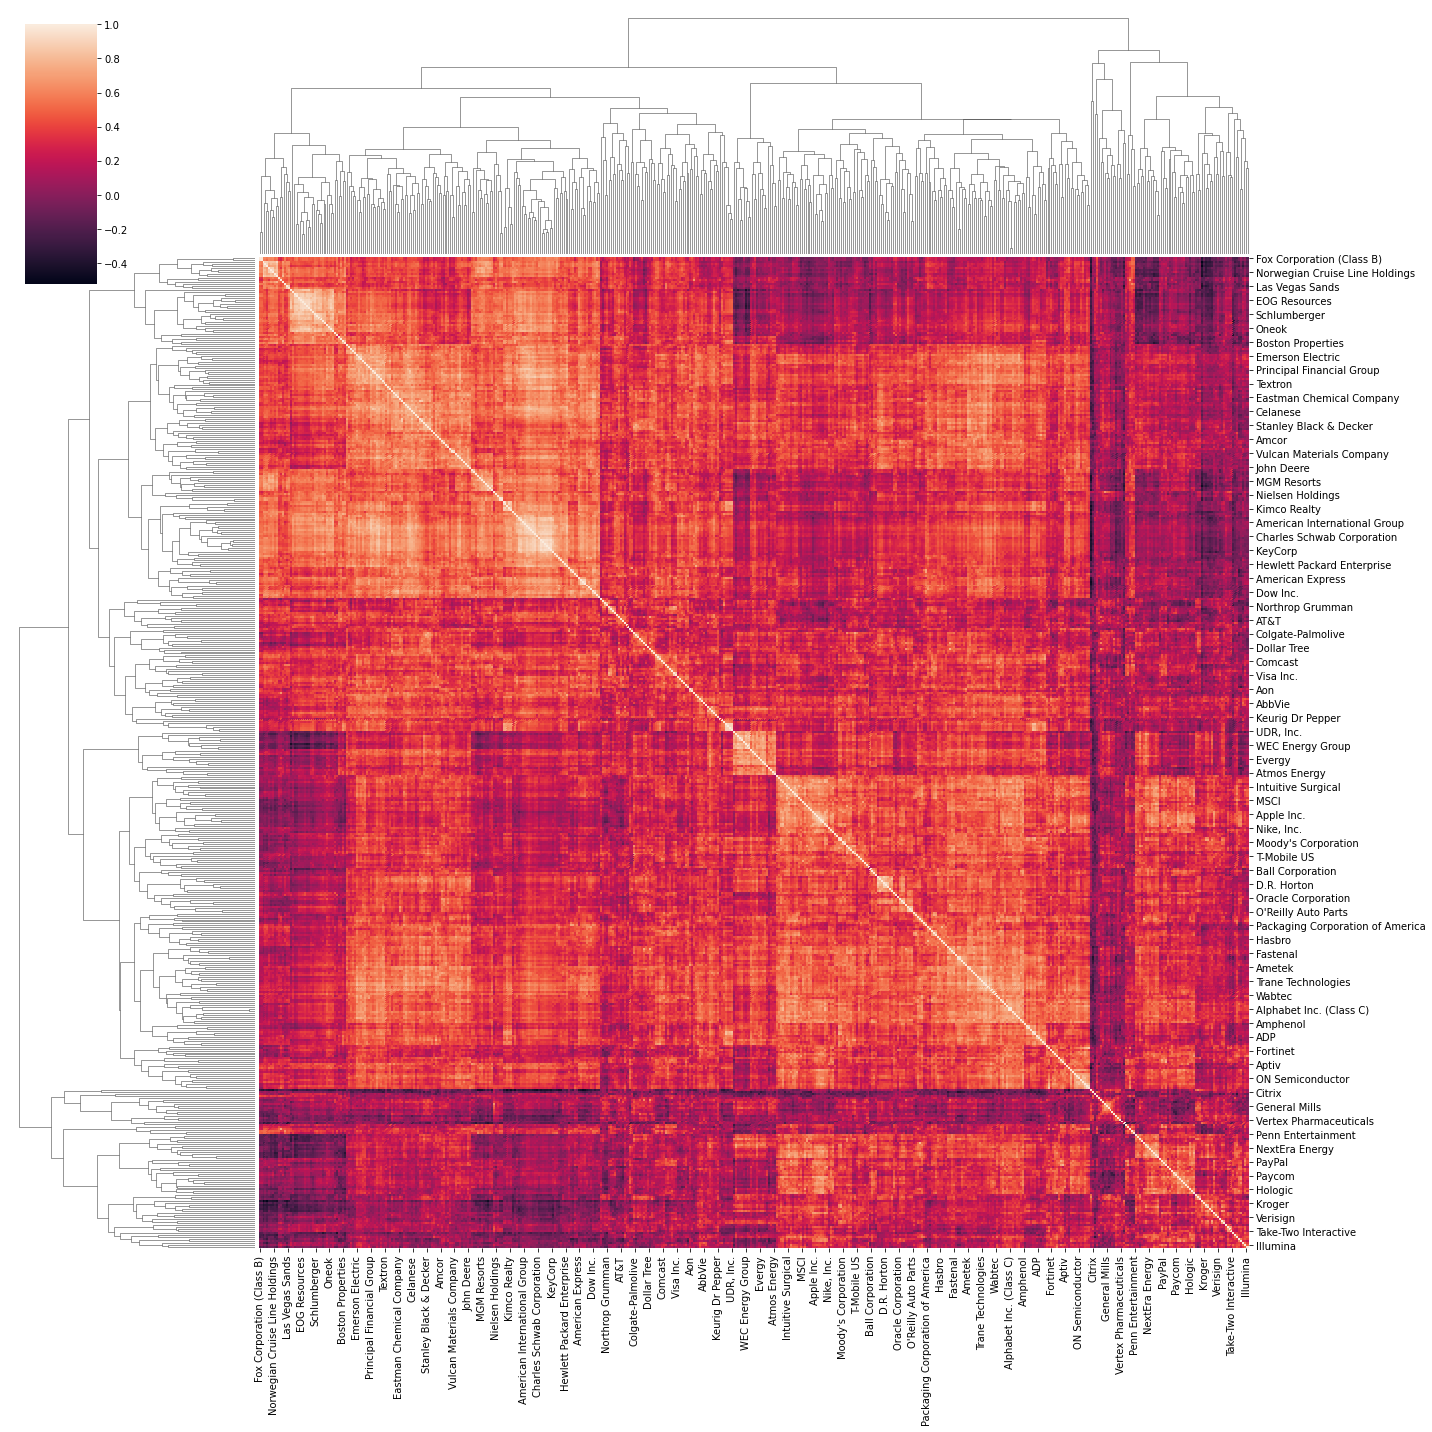

In [9]:
sns.clustermap(corr_, figsize=(20,20))

### The network graph

We proposed two ways to visualize multicollinearity. That is, using the heatmap and the clustermap. Although the latter was an improved way to visualize group of features that are strongly correlated, it can get very **tiresome** to interpret or can get awkward to retrieve insights from, especially if the number of features is large. This is especially the case with the **S&P500 dataset, which contains more than 500 features and even more** if you consider a longer timeframe or other NYSE exchanges. The biggest issue with these types of visualizations is that it shows **redundant information**. In other words, it shows features that are also weakly correlated. We are usually interested in strong correlations and plotting weak correlations is just not that interesting. Another major drawback is that the **visual space is not used wisely**. It is hard to tell where one group of features begins and when the other ends, and most importantly, how clusters of features are correlated with other features. There is a lot of information that is lost or difficult to distinguish. 

The network graph can alleviate most these issues. Below, it is generated using the **networkx** package. Using **networkx** and **Plotly**, we can create an interactive plot. In order to limit the number of interconnections between collinear features, only the Maximum Spanning Tree is taken. You can play around with the slider to increase the minimum correlation threshold which will evidently result in less stocks. I have also plotted stocks with the same sectors in a similar color. You can easily see how stocks are grouped according to their sectors.   

In [15]:
threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.05, continuous_update=False,
                                       orientation='horizontal', layout=Layout(width='500px'), style=dict(description_width="initial")
                                       )

network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode="lines", text=[], line=dict(color="MediumPurple", width=10), 
                                           marker=dict(size=20, line_width=10, line=dict(color="MediumPurple", width=2))),
                                go.Scatter(x=[], y=[], mode='markers+text', textposition="top center", text=[], hoverinfo='text',
                                           textfont_size=12, marker=dict(size=50, color=[], line_width=1))],
                          layout=go.Layout(showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0), width=1600, height=800))

df = prices.copy()
correlation_matrix = corr_.to_numpy()

In [23]:
def plot_corr_graph(change):
  threshold, corr_mode = None, None
  threshold = change.new

  tr_ind = np.triu_indices(correlation_matrix.shape[0])
  correlation_matrix[tr_ind] = 0
  G = nx.from_numpy_matrix(correlation_matrix)
  G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
  remove = []

  for col1, col2, weight in G.edges(data=True):
    if math.isnan(weight["weight"]):
      remove.append((col1, col2))
    if abs(weight["weight"]) < threshold:
      remove.append((col1, col2))
  G.remove_edges_from(remove)
  remvoe = []
  edges = list(sum(G.edges, ()))

  for node in G.nodes:
    if node not in edges:
      remove.append(node)
  G.remove_nodes_from(remove)
  mst = nx.maximum_spanning_tree(G)

  def assign_color(col):
    return sector_color_mapping[sp500_sector_mapping[col]]
  
  def assign_color_edge(correlation):
    if correlation < 0:
      return "#BF0603"
    else:
      return "#00CC66"
    edge_colors = []
    node_colors= []
    for key, value in nx.get_edge_attributes(mst, 'weight').items():
      edge_colors.append(assign_color_edge(value))
    for key, value in dict(mst.degree).items():
      node_colors.append(assign_color(key))

    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []

    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()

    for node, (x_,y_) in tree:
      node_x.append(x_)
      node_y.append(y_)

    def get_dim_of_node(name):
      for node , (x,y) in tree:
        if node == name:
          return x,y

    edge_x = []
    edge_y = []

    weights = []
    for node1, node2, w in mst.edges(data=True):
      x0, y0 = get_dim_of_node(node1)
      x1, y1 = get_dim_of_node(node2)
      edge_x.append(x0)
      edge_x.append(x1)
      edge_x.append(None)
      edge_y.append(y0)
      edge_y.append(y1)
      edge_y.append(None)
      weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))

    with network.batch_update():
      network.data[1].x = node_x
      network.data[1].y = node_y
      network.data[1].text = list(labels)
      network.data[1].marker.color = node_colors

      network.data[0].x = edge_x
      network.data[0].y = edge_y
      network.data[0].text = list(weights)
      network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice, network])

In [24]:
network

FigureWidget({
    'data': [{'line': {'color': 'MediumPurple', 'width': 10},
              'marker': {'line': …